Mount Google Drive and Unzip the Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive

!unzip /content/drive/MyDrive/'Forest Fire Dataset.zip' -d /content

!ls /content/'Forest Fire Dataset'

 animal_images	'Colab Notebooks'      'Forest Fire Dataset.zip'   tuned_models
 animals151	'Forest Fire Dataset'   models			  'Untitled document.gdoc'
Archive:  /content/drive/MyDrive/Forest Fire Dataset.zip
   creating: /content/Forest Fire Dataset/Testing/
  inflating: /content/Forest Fire Dataset/Testing/fire_0002.jpg  
  inflating: /content/Forest Fire Dataset/Testing/fire_0015.jpg  
  inflating: /content/Forest Fire Dataset/Testing/fire_0027.jpg  
  inflating: /content/Forest Fire Dataset/Testing/fire_0038.jpg  
  inflating: /content/Forest Fire Dataset/Testing/fire_0040.jpg  
  inflating: /content/Forest Fire Dataset/Testing/fire_0048.jpg  
  inflating: /content/Forest Fire Dataset/Testing/fire_0063.jpg  
  inflating: /content/Forest Fire Dataset/Testing/fire_0072.jpg  
  inflating: /content/Forest Fire Dataset/Testing/fire_0084.jpg  
  inflating: /content/Forest Fire Dataset/Testing/fire_0091.jpg  
  inflating: /content/Forest Fire Dataset/Testing/fire_0097.jpg  
  inflating: /c

In [3]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2

Step 1: Data Collection and Preprocessing


In [4]:
train_fire_dir = '/content/Forest Fire Dataset/Training/fire'
train_nofire_dir = '/content/Forest Fire Dataset/Training/nofire'
test_dir = '/content/Forest Fire Dataset/Testing'

In [5]:
def list_file_types_in_directory(directory):
    file_types = set([file.split('.')[-1] for file in os.listdir(directory)
                      if os.path.isfile(os.path.join(directory, file))])
    return file_types

train_fire_file_types = list_file_types_in_directory(train_fire_dir)
train_nofire_file_types = list_file_types_in_directory(train_nofire_dir)
test_file_types = list_file_types_in_directory(test_dir)

print("File types in Train Fire:", train_fire_file_types)
print("File types in Train No Fire:", train_nofire_file_types)
print("File types in Test:", test_file_types)

File types in Train Fire: {'jpg'}
File types in Train No Fire: {'jpg'}
File types in Test: {'jpg'}


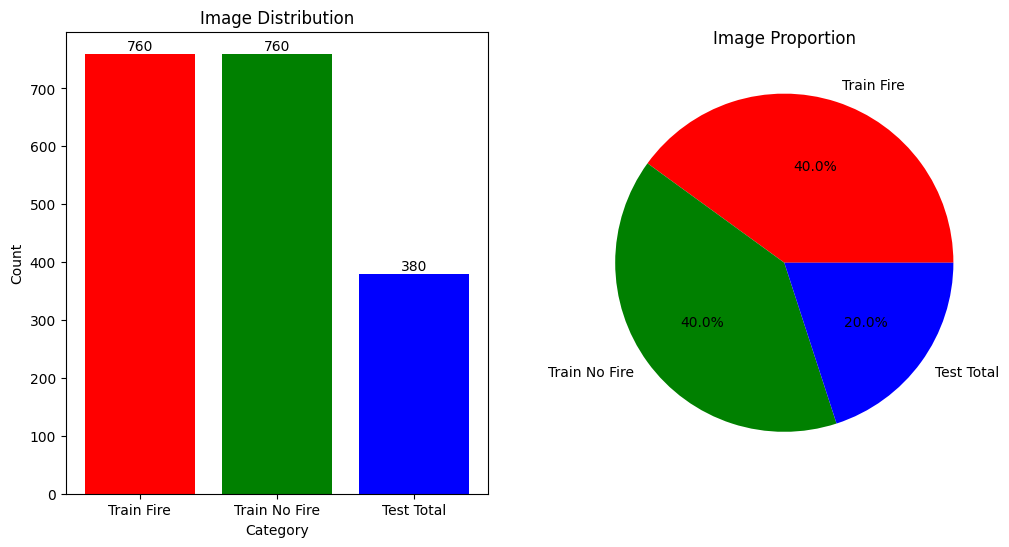

In [6]:
def count_images_in_directory(directory):
    return len([file for file in os.listdir(directory) if file.endswith('.jpg')])

train_fire_count = count_images_in_directory(train_fire_dir)
train_nofire_count = count_images_in_directory(train_nofire_dir)
test_total_count = count_images_in_directory(test_dir)

labels = ['Train Fire', 'Train No Fire', 'Test Total']
counts = [train_fire_count, train_nofire_count, test_total_count]

plt.figure(figsize=(12, 6))

# Bar chart
plt.subplot(1, 2, 1)
bars = plt.bar(labels, counts, color=['red', 'green', 'blue'])
plt.title('Image Distribution')
plt.xlabel('Category')
plt.ylabel('Count')

# Add counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['red', 'green', 'blue'])
plt.title('Image Proportion')

plt.show()


In [7]:
def load_images_from_directory(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(directory, filename))
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [8]:
train_fire_images, train_fire_labels = load_images_from_directory(train_fire_dir, 1)
train_nofire_images, train_nofire_labels = load_images_from_directory(train_nofire_dir, 0)

In [9]:
X_train = np.concatenate((train_fire_images, train_nofire_images), axis=0)
y_train = np.concatenate((train_fire_labels, train_nofire_labels), axis=0)

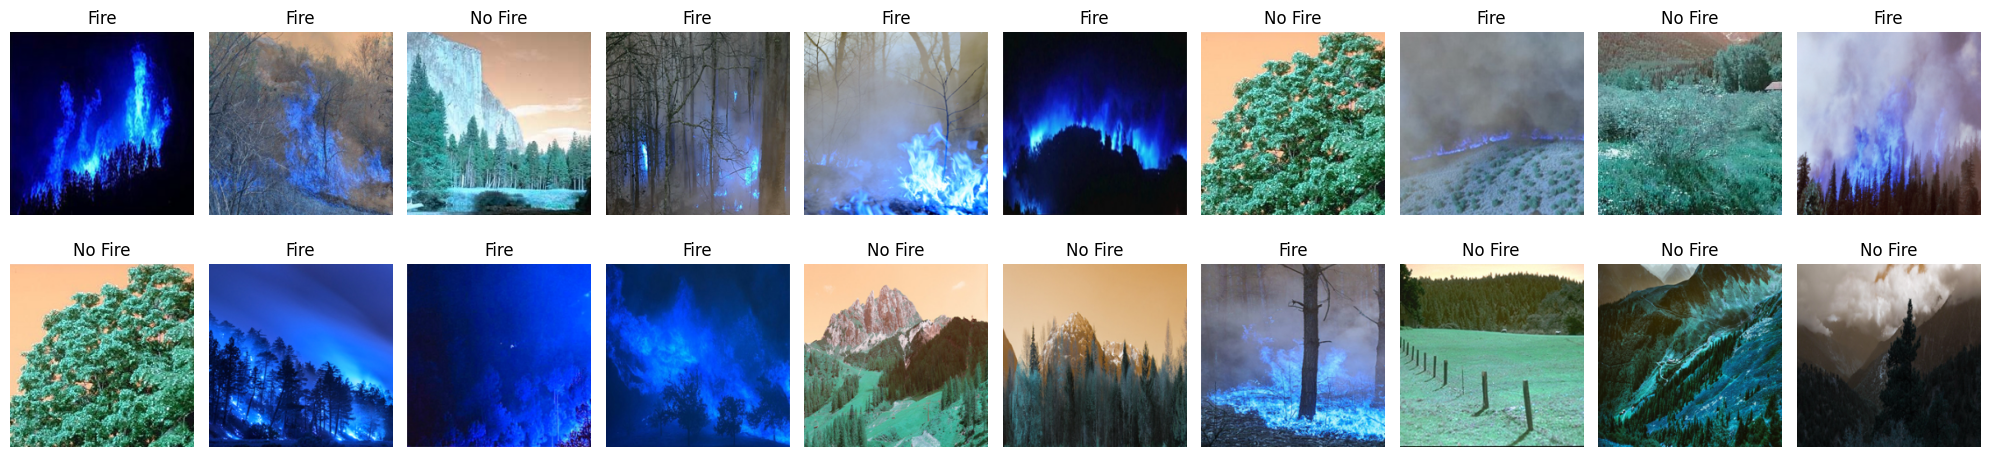

In [10]:
num_images_to_display = 20

plt.figure(figsize=(20, 5))

for i in range(num_images_to_display):

    index = np.random.randint(0, len(X_train))

    plt.subplot(2, 10, i + 1)
    plt.imshow(X_train[index])
    plt.title('Fire' if y_train[index] == 1 else 'No Fire')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
X_train = X_train / 255.0

In [12]:
test_images, _ = load_images_from_directory(test_dir, None)
test_images = test_images / 255.0

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [14]:
print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Testing data shape: {test_images.shape}')

Training data shape: (1216, 224, 224, 3)
Validation data shape: (304, 224, 224, 3)
Testing data shape: (380, 224, 224, 3)


Step 2: Building and Training the Fire Detection Model



In [15]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

X_augmented = []
y_augmented = []

for img, label in zip(X_train, y_train):
    augmented_img = datagen.random_transform(img)
    X_augmented.append(augmented_img)
    y_augmented.append(label)

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

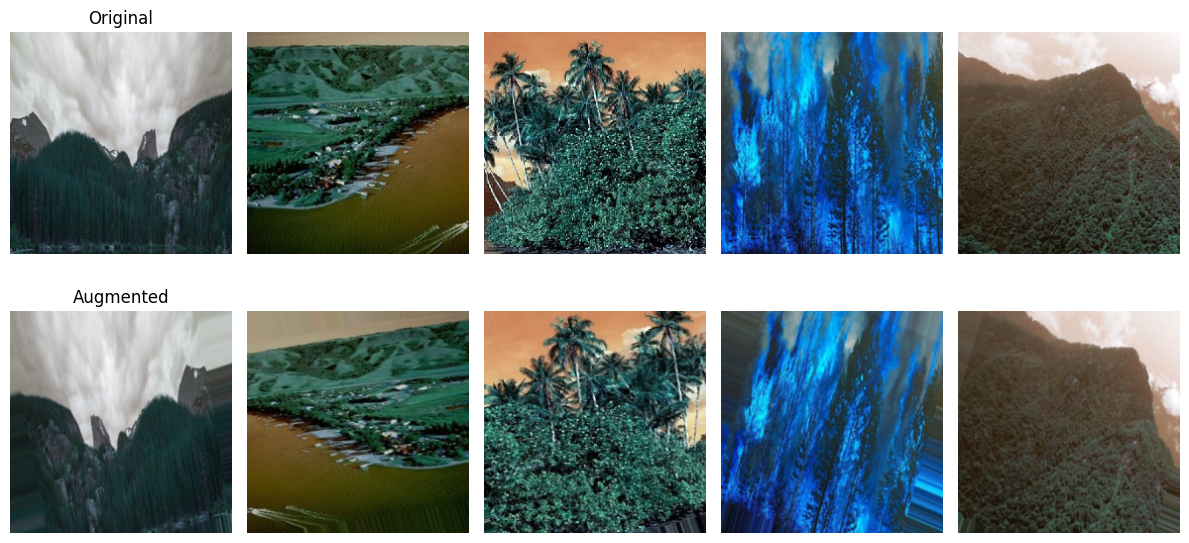

In [16]:
num_samples = 5

fig, axes = plt.subplots(2, num_samples, figsize=(12, 6))

for i in range(num_samples):
    axes[0, i].imshow(X_train[i])       # Original images
    axes[1, i].imshow(X_augmented[i])   # Augmented images

    axes[0, i].axis('off')
    axes[1, i].axis('off')

axes[0, 0].set_title("Original")
axes[1, 0].set_title("Augmented")

plt.tight_layout()
plt.show()

In [17]:
model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.25),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),

    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      11,944,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,963,457 (45.64 MB)

 Trainable params: 11,963,457 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_augmented, y_augmented,
    batch_size=32,
    epochs=5,
    validation_data=(X_val, y_val)
)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.7156 - loss: 3.3488 - val_accuracy: 0.9309 - val_loss: 1.1848
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9172 - loss: 0.9959 - val_accuracy: 0.9342 - val_loss: 0.7347
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.9202 - loss: 0.6306 - val_accuracy: 0.9375 - val_loss: 0.6375
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.9431 - loss: 0.5252 - val_accuracy: 0.9507 - val_loss: 0.6173
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.9584 - loss: 0.4627 - val_accuracy: 0.9507 - val_loss: 0.5413


In [19]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 561ms/step - accuracy: 0.9432 - loss: 0.5458
Validation Loss: 0.5413066744804382
Validation Accuracy: 0.9506579041481018


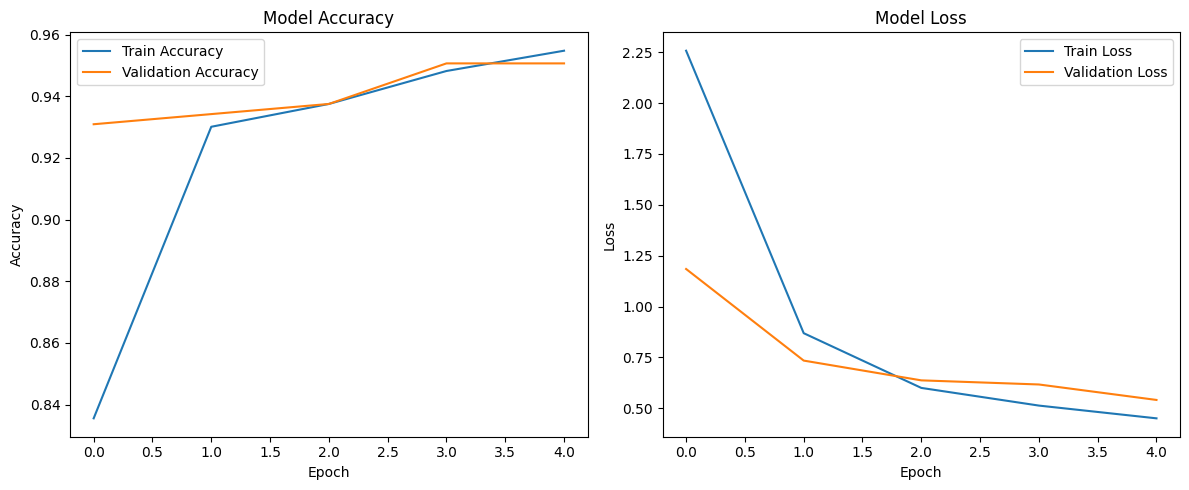

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Step **4**: Evaluate Model Performance

In [21]:
val_predictions = (model.predict(X_val) > 0.5).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 801ms/step


In [22]:
print("Classification Report:")
print(classification_report(y_val, val_predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       157
           1       0.94      0.96      0.95       147

    accuracy                           0.95       304
   macro avg       0.95      0.95      0.95       304
weighted avg       0.95      0.95      0.95       304



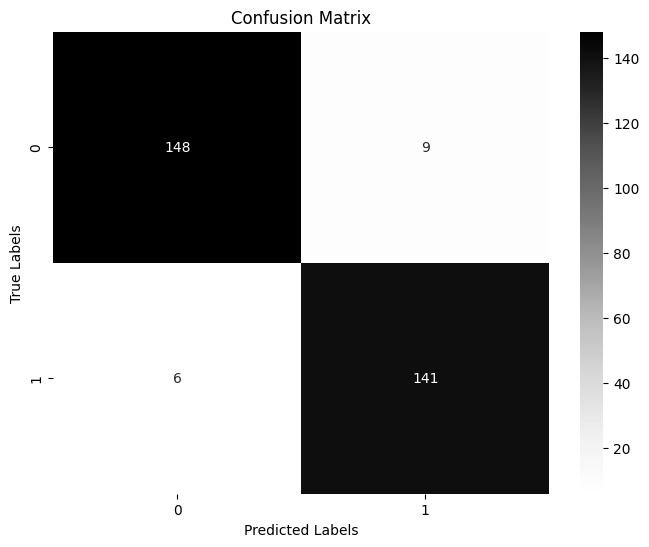

In [23]:
conf_matrix = confusion_matrix(y_val, val_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greys')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Step 5:Drone Deployment and Fire Suppression


In [24]:
test_image_names = os.listdir(test_dir)

test_predictions = model.predict(test_images)

test_predictions_binary = (test_predictions > 0.5).astype(int)

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 557ms/step


In [25]:
def get_high_risk_areas(test_image_names, test_predictions, top_n=10):
    high_risk_area = [(test_image_names[i], test_predictions[i]) for i in range(len(test_predictions))]
    high_risk_areas = sorted(high_risk_area, key=lambda x: x[1], reverse=True)
    return high_risk_areas[:top_n]

In [26]:
def display_high_risk_areas(high_risk_areas):
    print("Top high-risk areas (images with highest fire probabilities):")
    for area in high_risk_areas:
        print(f"Image: {area[0]}, Fire Probability: {area[1][0]}")

In [27]:
def simulate_drone_deployment(high_risk_area):
    print("\nSimulating drone deployment to the highest risk area...")
    print(f"Deploying drone to: {high_risk_area[0]} with fire probability: {high_risk_area[1][0]}")

In [28]:
high_risk_areas = get_high_risk_areas(test_image_names, test_predictions)
display_high_risk_areas(high_risk_areas)
simulate_drone_deployment(high_risk_areas[0])

Top high-risk areas (images with highest fire probabilities):
Image: fire_0827.jpg, Fire Probability: 0.9999992251396179
Image: fire_0564.jpg, Fire Probability: 0.9999505281448364
Image: fire_0927.jpg, Fire Probability: 0.9999446868896484
Image: fire_0545.jpg, Fire Probability: 0.9999158978462219
Image: fire_0329.jpg, Fire Probability: 0.9998523592948914
Image: fire_0478.jpg, Fire Probability: 0.9998494386672974
Image: fire_0583.jpg, Fire Probability: 0.9998438954353333
Image: fire_0542.jpg, Fire Probability: 0.9997642636299133
Image: fire_0289.jpg, Fire Probability: 0.9997612237930298
Image: fire_0371.jpg, Fire Probability: 0.9997556209564209

Simulating drone deployment to the highest risk area...
Deploying drone to: fire_0827.jpg with fire probability: 0.9999992251396179


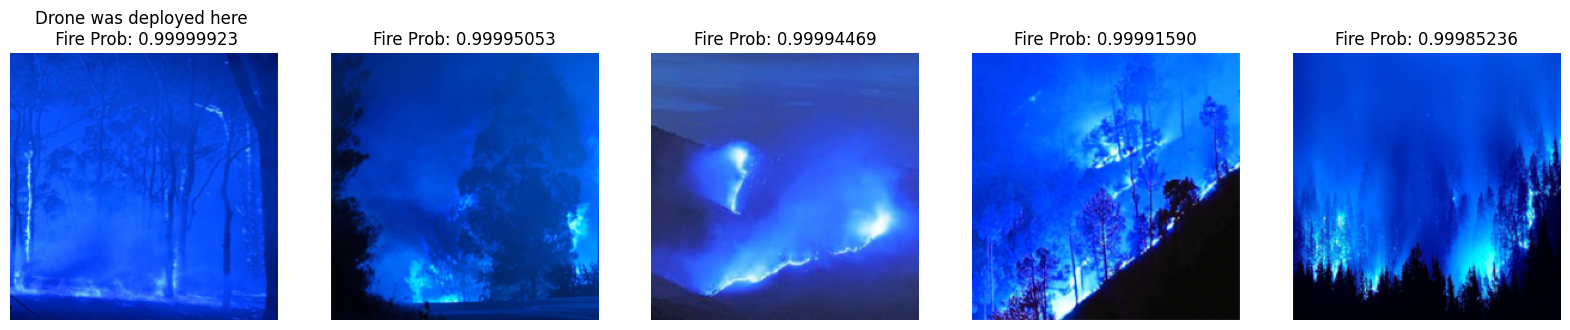

In [29]:
def visualize_high_risk_areas(test_images, high_risk_areas, test_image_names, num_images=10):
    plt.figure(figsize=(20, 20))
    for i in range(min(num_images, len(high_risk_areas))):
        image_name = high_risk_areas[i][0]
        img_index = test_image_names.index(image_name)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[img_index])
        fire_prob = high_risk_areas[i][1][0]
        if i == 0:
            plt.title(f'Drone was deployed here \n Fire Prob: {fire_prob:.8f}')
        else:
            plt.title(f'Fire Prob: {fire_prob:.8f}')
        plt.axis('off')
    plt.show()

# Visualize top 5 high-risk areas with floating point probabilities
visualize_high_risk_areas(test_images, high_risk_areas, test_image_names, num_images=5)

In [30]:
def log_high_risk_areas(high_risk_areas, log_file="high_risk_areas_log.txt"):
    with open(log_file, 'w') as f:
        f.write("Top high-risk areas (images with highest fire probabilities):\n")
        for area in high_risk_areas:
            fire_prob = area[1][0]
            f.write(f"Image: {area[0]}, Fire Probability: {fire_prob:.8f}\n")

log_high_risk_areas(high_risk_areas)

In [31]:
from google.colab import files
files.download("high_risk_areas_log.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>